# Producing GITM Plots for Gannon Storm Event

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
#from apexpy import Apex
import os
import datetime as dt
import importlib as il
import glob

#from p_tqdm import p_map
from multiprocessing import Pool
import itertools
from pysolar.solar import get_altitude
from dateutil import parser
import gc # garbage collection

In [6]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 1

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/gitm_extreme_storms/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/'
    scratch = '/home/pxv220016/scratch/'

utils = '/Users/prasoonv/repo/sat-interp-tid-analysis/'

import sys
sys
sys.path.append(f'{utils}prasoon_utility_programs')
sys.path.append(f'{utils}Qingyu_Cesar_EIA_IHA')
sys.path.append(f'{work}')
sys.path.append(f'{utils}Models/new/GITM/srcPython')

import gitm
import functions
import functions_gitm
import plot_3D_global
from mpl_toolkits.basemap import Basemap


In [7]:
import os
import multiprocessing

print(multiprocessing.cpu_count())
print(os.cpu_count())

8
8


In [4]:
import matplotlib
matplotlib.use('Agg')

In [8]:
# Assuming the required functions and libraries are already imported
functions_gitm = il.reload(functions_gitm)
plot_3D_global = il.reload(plot_3D_global)
 
# Set working directory and find files
path = f'{work}20240510/UA/data/'
os.chdir(path)
files = glob.glob('3DALL*.bin')
 
# Altitudes to be plotted
altitudes = [1.5e+5, 3e+5, 4.5e+5]
col = ['Altitude', 'Latitude', 'Longitude', 'Rho', 'Temperature', 'V!Dn!N (up)', 'V!Dn!N (north)', 'V!Dn!N (east)', 'LT']
 
# Process each file
for f in tqdm(files):
 
    #f = '3DALL_t240510_212500.bin'
    s = gitm.GitmBin(f)
    ds = functions_gitm.gitm_to_xarray(s)
    
    # Select relevant columns
    ds = ds[col]
    
    # Set up the figure with gridspec
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 1)  # 1 row, 3 columns
 
    # Loop through altitudes and create subplots for each
    for idx, a in enumerate(altitudes):
        ax = fig.add_subplot(gs[idx, 0])  # Assign each subplot to a grid position
        
        ds_a = ds.sel(alt=a, method='nearest')  # Select altitude
        # Convert latitudes and longitudes from radians to degrees
        ds_a['Latitude'] = ds_a['Latitude'] * (180 / np.pi)
        ds_a['Longitude'] = ds_a['Longitude'] * (180 / np.pi)
        ds_a.coords['lat'] = ds_a.coords['lat'] * (180 / np.pi)
        ds_a.coords['lon'] = ds_a.coords['lon'] * (180 / np.pi)
        ds_a = ds_a.where((ds_a['lon'] >= 0) & (ds_a['lon'] <= 360), drop=True)
        ds_a = ds_a.where((ds_a['lat'] >= -90) & (ds_a['lat'] <= 90), drop=True)
 
        # Extract variables
        lon = ds_a['lon'].values
        lat = ds_a['lat'].values
        vertical_v = ds_a['V!Dn!N (up)'].values
        north_v = ds_a['V!Dn!N (north)'].values
        east_v = ds_a['V!Dn!N (east)'].values
 
        # Set up the Basemap for this subplot
        m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, lon_0=180, resolution='l', ax=ax)
        
        # Create lat/lon meshgrid
        lon_grid, lat_grid = np.meshgrid(lon, lat)
        east_v_proj = east_v.T
        north_v_proj = north_v.T
        vertical_v_proj = vertical_v.T
        
        # Convert lat/lon to map coordinates
        x, y = m(lon_grid, lat_grid)
 
        # Plot the vertical velocity as a color map
        c = m.pcolormesh(x, y, vertical_v_proj, shading='auto', cmap='jet')
        cb = m.colorbar(c, location='right', pad='5%')
        cb.set_label('Vertical Velocity (m/s)')
 
        # Downsample the data for the quiver plot
        step = 4
        x_downsampled = x[::step, ::step]
        y_downsampled = y[::step, ::step]
        east_v_downsampled = east_v_proj[::step, ::step]
        north_v_downsampled = north_v_proj[::step, ::step]
 
        # Plot quiver
        quiver = m.quiver(x_downsampled, y_downsampled, east_v_downsampled, north_v_downsampled, scale=9000, color='k', pivot='middle', width=0.0015)
        
        # Add quiver key for reference
        ax.quiverkey(quiver, 10, 10, 5, label='5 m/s', labelpos='E', coordinates='figure', fontproperties={'size': 12})
        
        # Add map features
        m.drawcoastlines(color='gray')
        m.drawparallels(np.arange(-90, 91, 10), labels=[1, 0, 0, 0], fontsize=10)
        m.drawmeridians(np.arange(0, 361, 30), labels=[0, 0, 0, 1], fontsize=10)
        m.drawmapboundary(fill_color='white')
 
        # Adding terminators
        time_ut = dt.datetime.strptime(f'{f[7:-4]}', '%y%m%d_%H%M%S')
        m.nightshade(time_ut, alpha=0.13)
        
        # Title for the subplot
        ax.set_title(f'Altitude {int(a / 1000)} km', fontsize=14)
 
    # Add common title for the entire figure
    fig.suptitle(f'Neutral Wind Velocities during {f[7:9]}/{f[9:11]}/{f[11:13]} {f[14:16]}:{f[16:18]} UT', fontsize=16)
 
    # Show the plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)  # Adjust for the main title
    file_path = f'{work}/plots/cyl/{f[7:-4]}.jpg'
    plt.savefig(file_path)
    #plt.show()
    plt.close()

    del s, ds, ds_a, lon, lat, vertical_v, north_v, east_v, vertical_v_proj, north_v_proj, east_v_proj, north_v_downsampled, east_v_downsampled, x_downsampled, y_downsampled

    
    #break  # Remove this if you want to process all files
    gc.collect()

100%|█████████████████████████████████████| 1585/1585 [1:59:25<00:00,  4.52s/it]


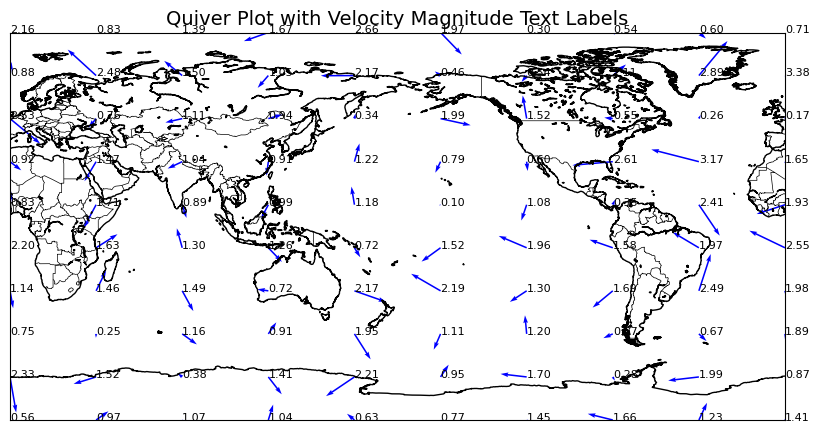

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Sample data
lons = np.linspace(0, 360, 10)
lats = np.linspace(-90, 90, 10)
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Sample velocity components
east_v = np.random.randn(10, 10)
north_v = np.random.randn(10, 10)

# Calculate the velocity magnitude (speed)
velocity_magnitude = np.sqrt(east_v**2 + north_v**2)

# Set up the Basemap
fig, ax = plt.subplots(figsize=(10, 7))
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=0, urcrnrlon=360, resolution='l', ax=ax)

m.drawcoastlines()
m.drawcountries()

# Convert lat/lon to map coordinates
x, y = m(lon_grid, lat_grid)

# Plot the quiver plot
quiver = m.quiver(x, y, east_v, north_v, scale=50, color='blue', width=0.002)

# Add a quiver key (scale indicator) for reference
ax.quiverkey(quiver, X=0.9, Y=0.1, U=5, label='5 m/s', labelpos='E', coordinates='figure', fontproperties={'size': 12})

# Add text labels for velocity magnitude
for i in range(len(lons)):
    for j in range(len(lats)):
        ax.text(x[i, j], y[i, j], f'{velocity_magnitude[i, j]:.2f}', color='black', fontsize=8)

plt.title('Quiver Plot with Velocity Magnitude Text Labels', fontsize=14)
plt.show()


/var/folders/0j/cdkpybh91qb3csbzkwm2tc_00000gn/T/ipykernel_27128/1090306501.py:95: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = m.pcolormesh(x, y, vertical_v_proj, shading='auto', cmap='coolwarm')


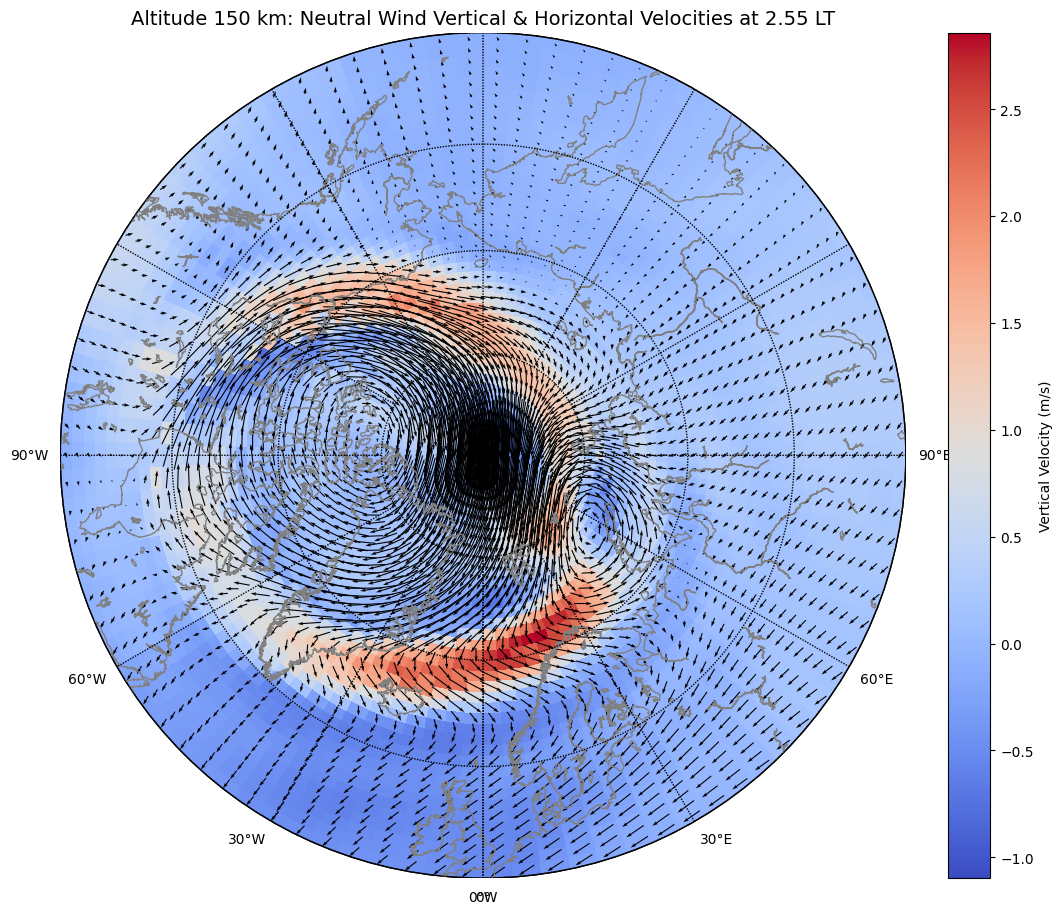

/var/folders/0j/cdkpybh91qb3csbzkwm2tc_00000gn/T/ipykernel_27128/1090306501.py:95: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = m.pcolormesh(x, y, vertical_v_proj, shading='auto', cmap='coolwarm')


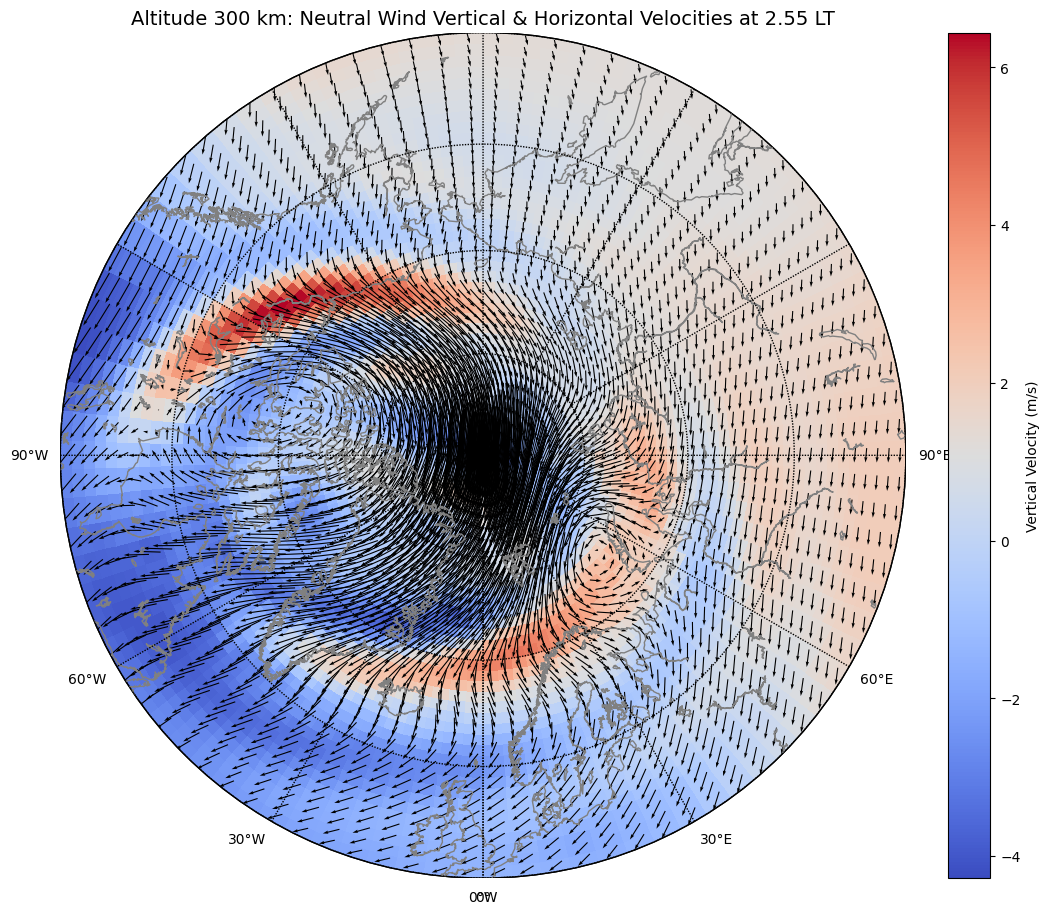

/var/folders/0j/cdkpybh91qb3csbzkwm2tc_00000gn/T/ipykernel_27128/1090306501.py:95: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = m.pcolormesh(x, y, vertical_v_proj, shading='auto', cmap='coolwarm')


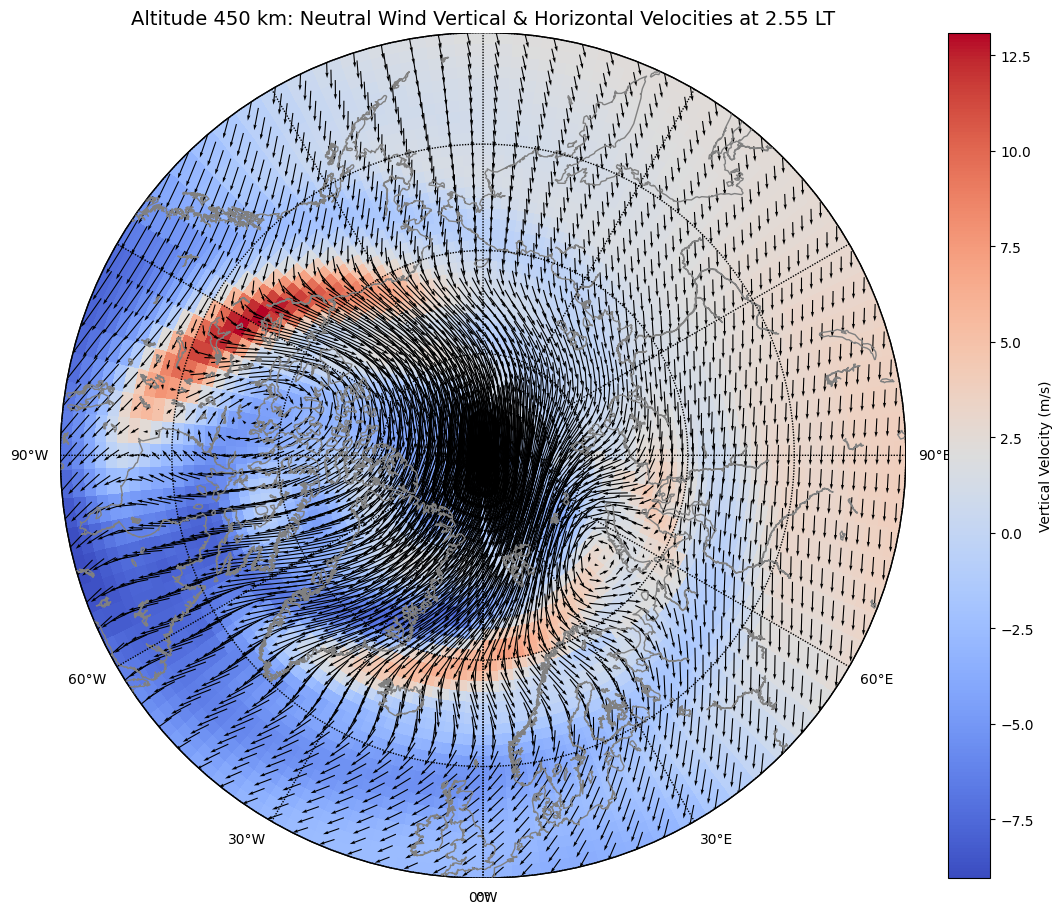

/var/folders/0j/cdkpybh91qb3csbzkwm2tc_00000gn/T/ipykernel_27128/1090306501.py:95: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = m.pcolormesh(x, y, vertical_v_proj, shading='auto', cmap='coolwarm')


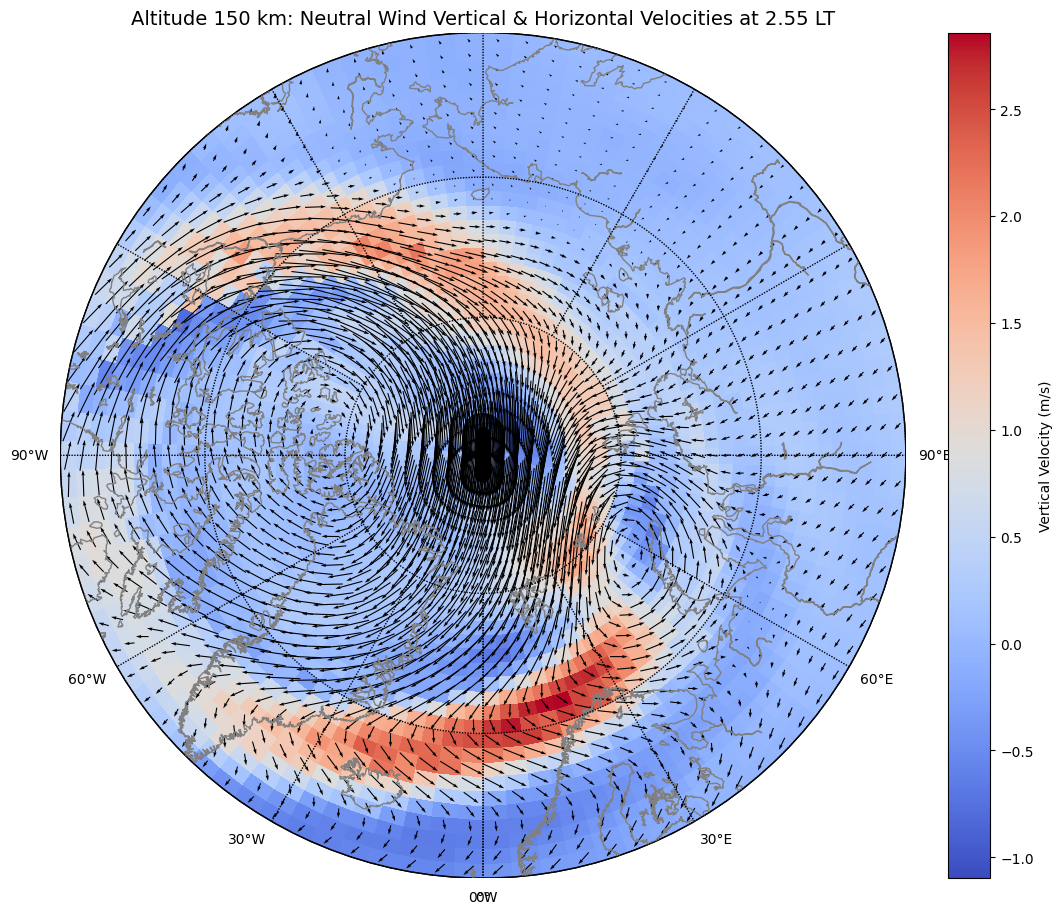

/var/folders/0j/cdkpybh91qb3csbzkwm2tc_00000gn/T/ipykernel_27128/1090306501.py:95: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = m.pcolormesh(x, y, vertical_v_proj, shading='auto', cmap='coolwarm')


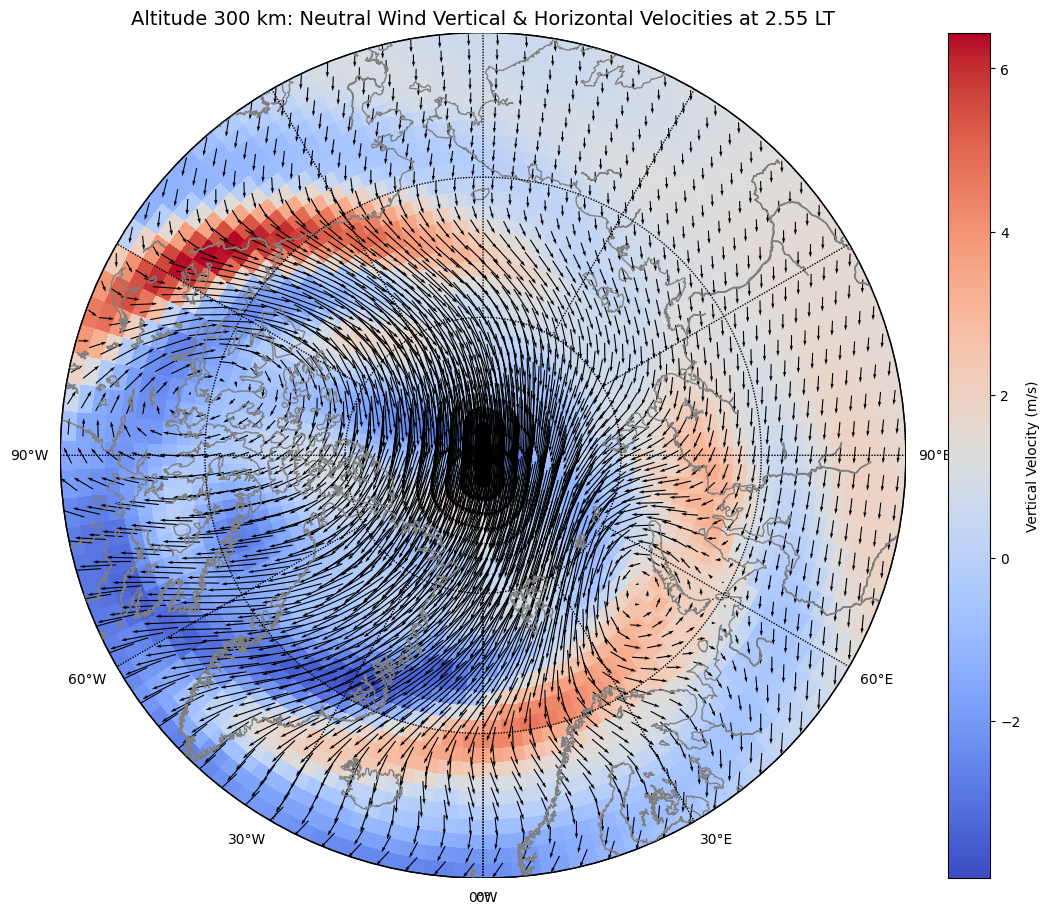

/var/folders/0j/cdkpybh91qb3csbzkwm2tc_00000gn/T/ipykernel_27128/1090306501.py:95: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = m.pcolormesh(x, y, vertical_v_proj, shading='auto', cmap='coolwarm')


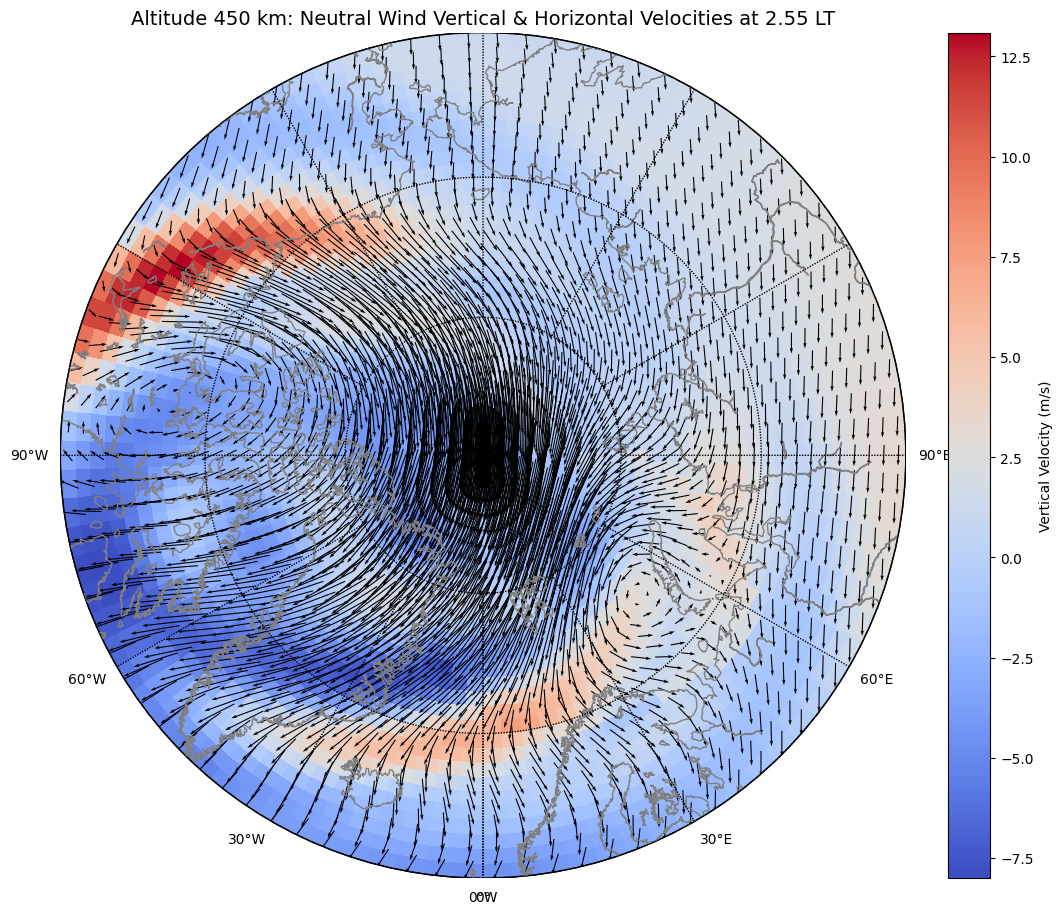

In [58]:
functions_gitm = il.reload(functions_gitm)
plot_3D_global = il.reload(plot_3D_global)
 
# Set working directory and find files
path = f'{work}20240510/UA/data/'
os.chdir(path)
files = glob.glob('3DALL*.bin')
 
# Process each file
for f in files:
    s = gitm.GitmBin(f)
    ds = functions_gitm.gitm_to_xarray(s)
    # Print dataset structure
    #print(ds)
 
    # Select relevant columns
    alt = [1.5e+5, 3e+5, 4.5e+5]
    col = ['Altitude', 'Latitude', 'Longitude', 'Rho', 'Temperature', 'V!Dn!N (up)', 'V!Dn!N (north)', 'V!Dn!N (east)', 'LT']
    ds = ds[col]


    latlim = [50, 60]
    # Loop through 90-50 range and 90-60 range
    for ll in latlim:

        
        # Loop through altitudes
        for a in alt:
            # Try selecting the correct dimension for altitude
            # Change 'alt' to the actual name of the altitude dimension if it's different
            ds_a = ds.sel(alt=a, method='nearest')  # Adjust 'alt' if needed
    
            # Convert latitudes and longitudes from radians to degrees
            ds_a['Latitude'] = ds_a['Latitude'] * (180 / np.pi)
            ds_a['Longitude'] = ds_a['Longitude'] * (180 / np.pi)
            ds_a.coords['lat'] = ds_a.coords['lat'] * (180 / np.pi)
            ds_a.coords['lon'] = ds_a.coords['lon'] * (180 / np.pi)
            ds_a = ds_a.where((ds_a['lat'] > -90) & (ds_a['lat'] < 90), drop=True)
            ds_a = ds_a.where((ds_a['lon'] > 0) & (ds_a['lon'] <= 360), drop=True)
        
            
            # Assuming ds_a is your dataset with latitude, longitude, and velocity components
            # Subset data for latitudes 90 to 50 degrees        
            ds_subset = ds_a.where((ds_a['lat'] >= ll) & (ds_a['lat'] <= 90), drop=True)
            #print(ds_subset)
            # Extract variables
            lon = ds_subset['lon'].values
            lat = ds_subset['lat'].values
            vertical_v = ds_subset['V!Dn!N (up)'].values  # Vertical velocity (color map)
            north_v = ds_subset['V!Dn!N (north)'].values  # Meridional velocity (quiver)
            east_v = ds_subset['V!Dn!N (east)'].values    # Zonal velocity (quiver)
            #east_v = np.full((90,90 - ll), -1)  # for testing
            #north_v = np.full((90,90 - ll), 1)  # for testing
            
            #print(vertical_v.shape)
            #print(north_v.shape)
            #print(east_v.shape)
    
    
            '''
            plt.figure()
            plt.plot(lat, vertical_v[22][:], label='vertical')
            plt.plot(lat, north_v[22][:], label='north')
            plt.plot(lat, east_v[22][:], label='east')
            plt.xlabel('Latitudes')
            plt.legend()
            plt.title(f'Longitude {lon[22]}')
            plt.show()
            '''
            
            
            # Set up the polar stereographic Basemap instance
            fig, ax = plt.subplots(figsize=(12, 12))
            m = Basemap(
                projection='npstere', 
                boundinglat=ll, 
                lon_0=0,
                round='True',
                resolution='l', 
                ax=ax)
            # Create lat/lon meshgrid
            lon_grid, lat_grid = np.meshgrid(lon, lat)
            #print("lon_grid shape:", lon_grid.shape)
            #print("lat_grid shape:", lat_grid.shape)
    
    
            east_v_proj, north_v_proj = m.rotate_vector(east_v.T, north_v.T, lon_grid, lat_grid)
            vertical_v_proj = vertical_v.T
            
            # Convert lat/lon to map coordinates
            x, y = m(lon_grid, lat_grid)
    
    
            # Plot the vertical velocity as a color map
            c = m.pcolormesh(x, y, vertical_v_proj, shading='auto', cmap='coolwarm')
            # Add a colorbar
            cb = m.colorbar(c, location='right', pad='5%')
            cb.set_label('Vertical Velocity (m/s)')
            
            # Add quiver plot for horizontal velocities
            quiver_scale = 5000  # Adjust scale based on the velocity magnitudes
            quiver = m.quiver(
                x, y, east_v_proj, north_v_proj,
                scale=quiver_scale, 
                color='k', 
                pivot='middle', 
                width=0.0013)
            # Add map features
            m.drawcoastlines(color='gray')
            m.drawparallels(np.arange(ll, 91, 10), labels=[1, 0, 0, 0], fontsize=10)
            m.drawmeridians(np.arange(0, 361, 30), labels=[0, 0, 0, 1], fontsize=10)
            m.drawmapboundary(fill_color='white')
    
            plt.title(f'Altitude {int(a / 1000)} km: Neutral Wind Vertical & Horizontal Velocities at {ds_subset.LT[0][0].values} LT', fontsize=14)
            plt.show()
     
 
 
    break  # Remove this if you want to process all altitudes

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Assume these are your wind components and coordinates
latitudes = np.linspace(50, 90, 41)  # From 50° to 90° latitude
longitudes = np.linspace(0, 360, 361)  # Full range of longitudes
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)  # Create a grid

# Meridional, zonal, and vertical winds (replace with actual data)
V_north = np.random.uniform(-50, 50, lon_grid.shape)  # Meridional wind
V_east = np.random.uniform(-50, 50, lon_grid.shape)   # Zonal wind
V_up = np.random.uniform(-10, 10, lon_grid.shape)     # Vertical wind

# Convert lat/lon to radians for polar plotting
lat_radians = np.radians(90 - lat_grid)  # Colatitude
lon_radians = np.radians(lon_grid)

# Create Basemap polar stereographic projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
m = Basemap(projection='npstere', boundinglat=50, lon_0=0, resolution='l', ax=ax)

# Draw parallels and meridians
m.drawparallels(np.arange(50, 91, 10), labels=[True, True, False, False])
m.drawmeridians(np.arange(0, 360, 30), labels=[True, True, True, True])

# Project lat/lon coordinates
x, y = m(lon_grid, lat_grid)

# Plot quiver for horizontal winds (zonal and meridional)
quiver = m.quiver(x, y, V_east, V_north, V_up, cmap='coolwarm', scale=1000)

# Add a colorbar for vertical winds
cbar = m.colorbar(quiver, location='bottom', pad="5%")
cbar.set_label("Vertical Winds (m/s)")

# Title and show the plot
plt.title("Polar Plot: Winds from 90° to 50° Latitude", fontsize=14)
plt.show()


ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [7]:
# os.chdir("/Users/prasoonv/repo/sat-interp-tid-analysis/gitm_extreme_storms/20240510/UA/")
# files = os.listdir("/Users/prasoonv/repo/sat-interp-tid-analysis/gitm_extreme_storms/20240510/UA/data/")
# gitm.GitmBin()

In [4]:
os.chdir("/Users/prasoonv/repo/sat-interp-tid-analysis/gitm_extreme_storms/20240510/UA/data/")
files = glob.glob("3DALL*.bin")

In [5]:
# gitmil = il.reload(gitm)

sample = gitm.GitmBin(files[0])

In [6]:
sample


GITM binary output file 3DALL_t240509_022500.bin

In [8]:
def gitm_to_xarray(gitm_bin):
    # Extract attributes from the GITM binary file
    attrs = gitm_bin.attrs
    nLon = attrs['nLon']  # Number of longitude grid points
    nLat = attrs['nLat']  # Number of latitude grid points
    nAlt = attrs['nAlt']  # Number of altitude grid points
    nVars = attrs['nVars']  # Number of variables

    # Extract data and reshape it
    data_vars = {}
    for key in list(gitm_bin.keys())[1:]:  # Skip the first key if it's not a data variable
        data = np.array(gitm_bin[key])  # Convert data to a NumPy array
        data = data.reshape((nLon, nLat, nAlt))  # Reshape data to match the grid dimensions
        data_vars[key] = (['lon', 'lat', 'alt'], data)  # Store data with corresponding coordinates

    # Define coordinates for the xarray.Dataset
    coords = {
        'lon': gitm_bin['Longitude'][:, 0, 0],  # Longitude values
        'lat': gitm_bin['Latitude'][0, :, 0],  # Latitude values
        'alt': gitm_bin['Altitude'][0, 0, :],  # Altitude values
    }

    # Create an xarray.Dataset with the data variables and coordinates
    ds = xr.Dataset(data_vars, coords=coords, attrs=attrs)
    return ds

In [9]:
gitm_data = gitm_to_xarray(sample)

In [10]:
gitm_data

<xarray.Dataset> Size: 321MB
Dimensions:                           (lon: 94, lat: 184, alt: 54)
Coordinates:
  * lon                               (lon) float64 752B -0.1047 ... 6.388
  * lat                               (lat) float64 1kB -1.597 -1.58 ... 1.597
  * alt                               (alt) float64 432B 9.645e+04 ... 9.14e+05
Data variables: (12/43)
    Longitude                         (lon, lat, alt) float64 7MB -0.1047 ......
    Latitude                          (lon, lat, alt) float64 7MB -1.597 ... ...
    Altitude                          (lon, lat, alt) float64 7MB 9.645e+04 ....
    Rho                               (lon, lat, alt) float64 7MB 1.153e-06 ....
    O(!U3!NP)                         (lon, lat, alt) float64 7MB 8.913e+17 ....
    O!D2!N                            (lon, lat, alt) float64 7MB 4.215e+18 ....
    ...                                ...
    V!Di!N (east)                     (lon, lat, alt) float64 7MB -16.7 ... 0...
    V!Di!N (north)                    (lon, lat, alt) float64 7MB 16.4 ... -0...
    V!Di!N (up)                       (lon, lat, alt) float64 7MB 0.05302 ......
    dLat                              (lon, lat, alt) float64 7MB -91.5 ... 91.5
    dLon                              (lon, lat, alt) float64 7MB -6.0 ... 366.0
    LT                                (lon, lat, alt) float64 7MB 2.017 ... 2...
Attributes:
    file:     3DALL_t240509_022500.bin
    endian:   big
    version:  21.14
    nLon:     94
    nLat:     184
    nAlt:     54
    nVars:    40